In [2]:
import numpy as np
from cvxopt import matrix, solvers, log, exp
import matplotlib.pyplot as plt

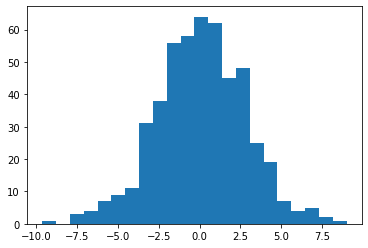

In [3]:
N = 50
M = 10

rank = 5

U_true = np.random.randn(N, rank)
V_true = np.random.randn(M, rank)

R_true = U_true @ V_true.T + 0.05 * np.random.randn(N, M)

plt.hist(R_true.flatten(), bins=np.int32(np.sqrt(N * M)))

C = 5 * np.ones(M)

minmax = np.nanmin(R_true) , np.nanmax(R_true) 

In [21]:
def solving_system(R, C, reg=1e-5, init_sol = None):
    N, M = R.shape
    A1 = np.zeros((N, N * M))
    for i in range(N):
        A1[i, i * M:(i + 1) * M] = np.ones((M))

    A2 = np.zeros((M, N * M))
    for i in range(M):
        A2[i, i:N * M:M] = np.ones((N))
      
    A = np.concatenate((A1, A2, -1 * np.identity(N * M)))
    
    c = -1 * R.reshape((N * M, 1))

    b = np.concatenate((np.ones(N), C, np.zeros(N * M)))
      
    P = reg * np.identity(N * M)
    solvers.options['show_progress'] = False
    sol = solvers.qp(matrix(P, tc='d'), matrix(c, tc='d'), matrix(A, tc='d'), matrix(b, tc='d'), initvals = init_sol)
    x_sys = np.array(sol['x']).reshape((N, M))
    q_sys = np.array(sol['z'])
    return x_sys, q_sys, sol

In [4]:
x, q, _ = solving_system(R_true, C)

5
139.19926346718105


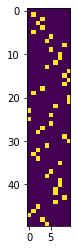

In [5]:
x = np.int32(x > 0.5)
plt.imshow(x)
print(np.max(np.sum(x, axis=0)))
print(np.sum(x * R_true))

14.0
157.15736526068935


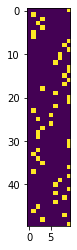

In [6]:
max_ind = np.argmax(R_true, axis=1)
x_without_C = np.zeros((N, M))
x_without_C[np.arange(N), max_ind] = 1
plt.imshow(x_without_C)
print(np.max(np.sum(x_without_C, axis=0)))
print(np.sum(x_without_C * R_true))

In [7]:
alpha = 2

data_sum = np.zeros((N, M))
data_counts = np.zeros((N, M))
    
def update_ucb(observations):

    for obs in observations:
        data_sum[obs[0], obs[1]] += obs[2]
        data_counts[obs[0], obs[1]] += 1
        
    #     print(data_counts)
            
    rand = np.random.randn(N, M)
    data_sum[data_counts == 0] = 10 + 0.01 * rand[data_counts == 0]
    data_counts[data_counts == 0] = 1
    
    R_UCB = data_sum / data_counts
    std = alpha / np.sqrt(data_counts)
        
    return R_UCB + std

Generate set initial observations

In [8]:
import torch
from torch import nn
from torch import optim
from torch.nn import functional as F 
from torch.optim.lr_scheduler import _LRScheduler
import math
from itertools import zip_longest, product

In [9]:
class EmbeddingNet(nn.Module):

    def __init__(self, n_users, n_items,
                n_user_factors=2, n_item_factors = 1, embedding_dropout=0.02, 
                hidden=10, dropouts=0.2):
        super().__init__()
        hidden = get_list(hidden)
        dropouts = get_list(dropouts)
        n_last = hidden[-1]
        
        def gen_layers(n_in):

            nonlocal hidden, dropouts
            assert len(dropouts) <= len(hidden)
            
            for n_out, rate in zip_longest(hidden, dropouts):
                yield nn.Linear(n_in, n_out)
                yield nn.ReLU()
                if rate is not None and rate > 0.:
                    yield nn.Dropout(rate)
                n_in = n_out
            
        self.u = nn.Embedding(n_users, n_user_factors)
        self.m = nn.Embedding(n_items, n_item_factors)
        self.drop = nn.Dropout(embedding_dropout)
        self.hidden = nn.Sequential(*list(gen_layers(n_user_factors + n_item_factors))) # to handle self.d (delays) 
        self.fc = nn.Linear(n_last, 1) 
        self._init()
        self.double()
        
    def forward(self, users, items, minmax):
        features = torch.cat([self.u(users), self.m(items)], dim=1)
        x = self.drop(features)
        x = self.hidden(x)
        out = torch.sigmoid(self.fc(x))
        
        if minmax is not None:
          
            min_rating, max_rating = minmax
            out = out*(max_rating - min_rating + 1) + min_rating - 0.5 
        
        return out

    #     return out
    def _init(self):
        """
        Setup embeddings and hidden layers with reasonable initial values.
        """
        def init(m):
            if type(m) == nn.Linear:
                torch.nn.init.xavier_uniform_(m.weight)
                m.bias.data.fill_(0.01)
            
                
        self.u.weight.data.uniform_(-0.05, 0.05)
        self.m.weight.data.uniform_(-0.05, 0.05)
        # self.d.weight.data.uniform_(-0.05, 0.05)

        self.hidden.apply(init)
        init(self.fc)
        
def get_list(n):
    if isinstance(n, (int, float)):
        return [n]
    elif hasattr(n, '__iter__'):
        return list(n)
    raise MypeError('layers configuraiton should be a single number or a list of numbers')

In [10]:
class CyclicLR(_LRScheduler):
    
    def __init__(self, optimizer, schedule, last_epoch=-1):
        assert callable(schedule)
        self.schedule = schedule
        super().__init__(optimizer, last_epoch)

    def get_lr(self):
        return [self.schedule(self.last_epoch, lr) for lr in self.base_lrs]
    
def cosine(t_max, eta_min=0):
    
    def scheduler(epoch, base_lr):
        t = epoch % t_max
        return eta_min + (base_lr - eta_min)*(1 + math.cos(math.pi*t/t_max))/2
    
    return scheduler

In [11]:
class ReviewsIterator:
      
    def __init__(self, X, y, batch_size=32, shuffle=True): 
        
        X = np.array(X)
        y = np.array(y)
                
        if shuffle:
            index = np.random.permutation(X.shape[0])
            X, y = X[index], y[index]
            
        self.X = X
        self.y = y
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.n_batches = int(math.ceil(X.shape[0] // batch_size))
        self._current = 0
        
    def __iter__(self):
        return self
    
    def __next__(self):
        return self.next()
    
    def next(self):
        if self._current >= self.n_batches:
            raise StopIteration()
        k = self._current
        self._current += 1
        bs = self.batch_size
        return self.X[k*bs:(k + 1)*bs], self.y[k*bs:(k + 1)*bs]

def batches(X, y, bs=256, shuffle=True):
    for xb, yb in ReviewsIterator(X, y, bs, shuffle):
        xb = torch.LongTensor(xb)
        yb = torch.DoubleTensor(yb)
        yield xb, yb

In [16]:
def train_net(net, observations, verbose=False):
    X_train = []
    y_train = []

    for obs in observations:
        X_train.append((obs[0], obs[1]))
        y_train.append(obs[2])

    dataset_size = len(X_train)
    
    lr = 1e-3
    wd = 1e-5
    bs = 50 # Batch Size: changed by merrick for kannan experiment
    n_epochs = 20
    patience = 10
    no_improvements = 0
    best_loss = np.inf
    best_weights = None
    history = []
    lr_history = []

    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

    net.to(device)
    criterion = nn.MSELoss(reduction='sum')
    optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=wd)
    iterations_per_epoch = int(math.ceil(dataset_size / bs))


    if verbose:
        print(iterations_per_epoch)

    scheduler = CyclicLR(optimizer, cosine(t_max=iterations_per_epoch * 2, eta_min=lr/10))
    counter = 0
    for epoch in range(n_epochs):
        stats = {'epoch': epoch + 1, 'total': n_epochs}

        running_loss = 0.0
        n_batches = 0
        batch_num = 0

        for batch in batches(X_train, y_train, shuffle=True, bs=bs):

            x_batch, y_batch = [b.to(device) for b in batch]
            optimizer.zero_grad()
            # compute gradients only during 'train' phase
            with torch.set_grad_enabled(True):
                outputs = net(x_batch[:, 0], x_batch[:, 1], minmax)

                loss = criterion(outputs.T, y_batch)

    #             print(loss)
    #             print("y_batch", y_batch)
    #             print("outputs", outputs)

                counter += 1

                # loss = torch.tensor(5.0, device='cuda:0', dtype=torch.float64, requires_grad=Mrue)
                scheduler.step()
                loss.backward()
                optimizer.step()
                lr_history.extend(scheduler.get_lr())

            running_loss += loss.item()

        epoch_loss = running_loss / dataset_size
        stats['train'] = epoch_loss

        history.append(stats)
        if verbose:
            print('[{epoch:03d}/{total:03d}] train: {train:.4f}'.format(**stats))
        
    return net

In [17]:
initial_data_size = int(N * M * 0.1)
observations = []

for _ in range(initial_data_size):
    i = np.random.choice(N)
    j = np.random.choice(M)
    observations.append((i, j, R_true[i, j] + 0.01 * np.random.randn()))
    
horizon = 300
alpha = 1

history = np.zeros(horizon)
prev_sol = None

indices = np.array(list(product(np.arange(N), np.arange(M))))
indices = torch.LongTensor(indices)
data_counts = np.zeros((N, M))

net = EmbeddingNet(n_users=N, n_items=M, n_user_factors = 100, n_item_factors = 100, hidden=[64, 64, 64], dropouts=0.2)

for t in range(horizon):
        
    net = train_net(net, observations)
    
    estimated_values = net(indices[:, 0], indices[:, 1], minmax)

    R_est = np.reshape(estimated_values.detach().numpy(), (N, M))
    
    for obs in observations:
        data_counts[obs[0], obs[1]] += 1
    
    data_counts[data_counts == 0] = 1
    std = alpha / np.sqrt(data_counts)

    R_UCB = R_est + std

    x_est, _, prev_sol = solving_system(R_UCB, C)
            
    x_est = np.int32(x_est > 0.5)

    if t % 3 == 0:
        print('Iter ', t)
        print(np.max(np.sum(x_est, axis=0)))
        print(np.sum(x_est, axis=0))
        print(np.sum(x_est * R_true))
    
    history[t] = np.sum(x_est * R_true)

    for i in range(N):
        for j in range(M):
            if x_est[i, j] == 1:
                observations.append((i, j, R_true[i, j] + np.random.randn()))

/Users/erginbas/opt/anaconda3/lib/python3.8/site-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([50])) that is different to the input size (torch.Size([1, 50])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/erginbas/opt/anaconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:131: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Iter  0
5
[5 5 5 5 5 5 5 5 5 5]
11.733735935933558
Iter  3
5
[0 5 5 3 5 5 5 3 3 5]
59.00989031977631
Iter  6
5
[5 5 5 1 5 5 5 1 4 5]
66.3438500107853
Iter  9
5
[5 5 5 4 5 5 5 2 3 5]
84.5996530819375
Iter  12
5
[5 5 4 3 5 5 5 2 5 5]
94.08512455036686
Iter  15
5
[5 5 5 2 5 5 5 2 5 5]
97.11260403495112
Iter  18
5
[5 5 5 3 3 5 5 3 4 5]
96.72056064288424
Iter  21
5
[5 5 5 3 5 5 5 3 3 5]
102.9882759150686
Iter  24
5
[3 5 5 3 4 5 5 4 5 5]
111.49886767960635
Iter  27
5
[5 5 5 3 5 5 5 4 4 5]
103.52670788898075
Iter  30
5
[4 5 5 3 5 5 5 4 3 5]
105.65612857835514
Iter  33
5
[3 5 5 4 3 5 5 4 5 5]
109.54323996379091
Iter  36
5
[2 5 5 4 5 5 5 5 4 5]
111.15391762049236
Iter  39
5
[3 5 5 3 5 5 5 4 5 5]
115.56205009689499
Iter  42
5
[4 5 5 3 5 5 5 3 5 5]
111.11806416089055
Iter  45
5
[4 5 5 3 5 5 5 5 5 5]
117.29605799488101
Iter  48
5
[5 5 5 3 5 4 5 5 5 5]
121.94254381854168
Iter  51
5
[5 5 4 3 5 5 5 5 5 5]
122.08488369663823
Iter  54
5
[5 5 5 3 5 5 5 5 5 5]
122.54646438211647
Iter  57
5
[5 5 5 3 5 5 5

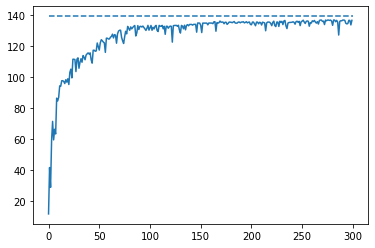

In [18]:
plt.plot(np.arange(horizon), history)
plt.hlines(np.sum(x * R_true), 0, horizon, linestyles='dashed')

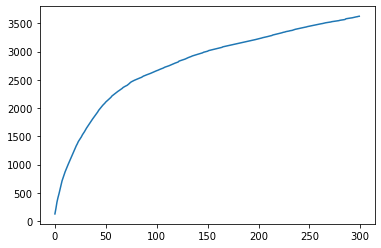

In [19]:
plt.plot(np.arange(horizon), np.cumsum(np.sum(x * R_true) - history))